In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender


In [2]:
import sys
sys.path.append('../../')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [4]:
# import json
import logging
import pandas as pd
# import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from tqdm.auto import tqdm

# from dltranz.data_load.data_module.cls_data_module import ClsDataModuleTrain

from dltranz.seq_to_target import SequenceToTarget


In [5]:
from dltranz.util import get_cls

In [6]:
from pyhocon import ConfigFactory

In [7]:
import torch

In [8]:
import numpy as np

In [9]:
from torch.utils.data import DataLoader

from dltranz.data_load import padded_collate, IterableChain, IterableAugmentations
from dltranz.data_load.augmentations.build_augmentations import build_augmentations
from dltranz.data_load.data_module.map_augmentation_dataset import MapAugmentationDataset
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load.iterable_processing.feature_filter import FeatureFilter
from dltranz.data_load.iterable_processing.feature_type_cast import FeatureTypeCast
from dltranz.data_load.iterable_processing.seq_len_filter import SeqLenFilter
from dltranz.data_load.parquet_dataset import ParquetFiles, ParquetDataset


In [10]:
from dltranz.data_load.list_splitter import ListSplitter
from dltranz.data_load.iterable_processing.target_join import TargetJoin
from dltranz.data_load.iterable_processing.id_filter import IdFilter

In [11]:
from dltranz.train import score_model2

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from dltranz.models import create_head_layers
from dltranz.trx_encoder import PaddedBatch


In [ ]:
from itertools import islice, product

from IPython.display import display

In [12]:
config_text = """
{
  data_module: {
    setup: {
      dataset_files: {
        train_data_path: "data/train_trx.parquet"
        test_data_path: "data/test_trx.parquet"
      }
      target_file_path: "data/gender_train.csv"
      
      col_id: customer_id
      col_id_dtype: int
      col_target: gender

      substitute_part: 0.5
      valid_part: 0.1
    }

    train: {
        min_seq_len: 0
        augmentations: [
            [RandomSlice, {min_len: 250, max_len: 350, rate_for_min: 0.9}]
            [DropoutTrx, {trx_dropout: 0.01}]
        ]
        num_workers: 16
        batch_size: 32
    }

    valid: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 8
        batch_size: 64   # 512
    }
    test: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 20
        batch_size: 2000
    }
  }

  seed_everything: 42

  target:
  {
      logger_name: adv_target
      trainer: {
        gpus: 1
        auto_select_gpus: false

        max_epochs: 50

        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 2}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
      embed_params: {
          head_layers: [
            [Linear, {"in_features": 2, "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
          ]
          # w_c_loss: 0.02
          w_c_loss: 0.1
      }
  }
  
  substitute:
  {
      logger_name: adv_substitute
      trainer: {
        gpus: 1
        auto_select_gpus: false

        max_epochs: 50
        
        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
  }
}
"""

conf = ConfigFactory.parse_string(config_text)

In [13]:
if 'seed_everything' in conf:
    pl.seed_everything(conf['seed_everything'])

Global seed set to 42


In [14]:
logger = logging.getLogger(__name__)

In [15]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)-7s %(funcName)-20s   : %(message)s')

In [16]:
class DataSplitter:
    def __init__(self, conf):
        self.setup_conf = conf['setup']
        self.split()
        
    def split(self):
        train_data_files = ParquetFiles(self.setup_conf['dataset_files.train_data_path']).data_files
        test_data_files = ParquetFiles(self.setup_conf['dataset_files.test_data_path']).data_files

        target_subst_spliter = ListSplitter(
            train_data_files, valid_size=self.setup_conf['substitute_part'], seed=42)
        target_splitter = ListSplitter(
            target_subst_spliter.train, valid_size=self.setup_conf['valid_part'], seed=42)
        substitute_splitter = ListSplitter(
            target_subst_spliter.valid, valid_size=self.setup_conf['valid_part'], seed=42)
        
        self.target_train = target_splitter.train
        self.target_valid = target_splitter.valid
        
        self.substitute_train = substitute_splitter.train
        self.substitute_valid = substitute_splitter.valid
        
        self.test = test_data_files
    
    @property
    def target_files(self):
        return self.target_train, self.target_valid
        
    @property
    def substitute_files(self):
        return self.substitute_train, self.substitute_valid
        
    @property
    def test_files(self):
        return self.test,

In [17]:
class AdversarialTrainDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.train_conf = conf['train']
        self.valid_conf = conf['valid']
        
        self.train_files, self.valid_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()
        self.setup_map()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.train_dataset = ParquetDataset(
            self.train_files,
            post_processing=IterableChain(*self.build_iterable_processing('train')),
            shuffle_files=True,
        )
        self.valid_dataset = ParquetDataset(
            self.valid_files,
            post_processing=IterableChain(*self.build_iterable_processing('valid')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        if part == 'train':
            yield SeqLenFilter(min_seq_len=self.train_conf['min_seq_len'])
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)

    def build_augmentations(self, part):
        if part == 'train':
            return build_augmentations(self.train_conf['augmentations'])
        elif part == 'valid':
            return build_augmentations(self.valid_conf['augmentations'])

    def setup_map(self):
        self.train_dataset = list(tqdm(iter(self.train_dataset)))
        logger.info(f'Loaded {len(self.train_dataset)} for train model')
        self.valid_dataset = list(tqdm(iter(self.valid_dataset)))
        logger.info(f'Loaded {len(self.valid_dataset)} for valid model')

        self.train_dataset = MapAugmentationDataset(
            base_dataset=self.train_dataset,
            a_chain=self.build_augmentations('train'),
        )
        self.valid_dataset = MapAugmentationDataset(
            base_dataset=self.valid_dataset,
            a_chain=self.build_augmentations('valid'),
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            collate_fn=padded_collate,
            shuffle=True,
            num_workers=self.train_conf['num_workers'],
            batch_size=self.train_conf['batch_size'],
            drop_last=self.train_conf.get('drop_last', False)
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid_dataset,
            collate_fn=padded_collate,
            num_workers=self.valid_conf['num_workers'],
            batch_size=self.valid_conf['batch_size'],
        )

In [18]:
class AdversarialTestDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [19]:
data_splitter = DataSplitter(conf['data_module'])

In [20]:
class EmbeddingSequenceToTarget(SequenceToTarget):
    def __init__(self, params, embed_params):
        super().__init__(params)
        
        self.head2 = create_head_layers(embed_params, self._seq_encoder)
        self.w_c_loss = embed_params['w_c_loss']
        
    def training_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        bce_loss = self.loss(y_h, y)
        self.log('bce_loss', bce_loss, prog_bar=True)
        if isinstance(x, PaddedBatch):
            self.log('seq_len', x.seq_lens.float().mean(), prog_bar=True)
        if self.train_update_n_steps and self.global_step % self.train_update_n_steps == 0:
            for name, mf in self.train_metrics.items():
                mf(y_h, y)
        
        corr = torch.mm(z.T, z) / len(z)
        c_loss = (corr - torch.eye(len(corr), device=corr.device)).pow(2).sum() + z.mean(dim=0).pow(2).sum()

#         z = z / (z.pow(2).sum(dim=1, keepdims=True) + 1e-6).pow(0.5)
#         dd = ((z.view(1, -1, 2) - z.view(-1, 1, 2)).pow(2).sum(dim=2) + 1e-6).pow(0.5)
#         dd = torch.relu(0.2 - dd).pow(2)
#         # dd = torch.exp(-dd).mean()
#         c_loss = dd.sum() + z.mean(dim=0).pow(2).sum()
    
        self.log('c_loss', c_loss, prog_bar=True)
        
        loss = bce_loss + c_loss * self.w_c_loss
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        for name, mf in self.valid_metrics.items():
            mf(y_h, y)

    def test_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        for name, mf in self.test_metrics.items():
            mf(y_h, y)

In [21]:
l_conf = conf['target']

_target_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _target_trainer_params['logger'] = TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_target_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]

target_model = EmbeddingSequenceToTarget(l_conf['params'], l_conf['embed_params'])

target_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.target_files)
target_trainer = pl.Trainer(**_target_trainer_params)
target_trainer.fit(target_model, target_dm)

target_valid_metrics = {name: float(mf.compute().item()) for name, mf in target_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in target_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-04 12:11:53,285 INFO    setup_map              : Loaded 3030 for train model


0it [00:00, ?it/s]

2021-06-04 12:11:53,353 INFO    setup_map              : Loaded 363 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-04 12:11:56,900 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 194   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
6 | head2         | Sequential    | 3     
------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.8413, valid_accuracy: 0.7751


In [22]:
test_dm = AdversarialTestDataModule(conf['data_module'], target_model, *data_splitter.test_files)
test_dm.prepare_data()

In [23]:
target_trainer.test(model=target_model, test_dataloaders=test_dm.test_dataloader())
target_test_metrics = {name: float(mf.compute().item()) for name, mf in target_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in target_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7892857193946838, 'test_auroc': 0.8578282594680786}
--------------------------------------------------------------------------------
test_auroc: 0.8578, test_accuracy: 0.7893


In [24]:
target_emb_model = torch.nn.Sequential(
    target_model._seq_encoder,
    *target_model._head,
)

In [25]:
target_embeddings, y = tuple(score_model2(target_emb_model, test_dm.test_dataloader(), {}))

In [26]:
assert target_embeddings.shape[1] == 2

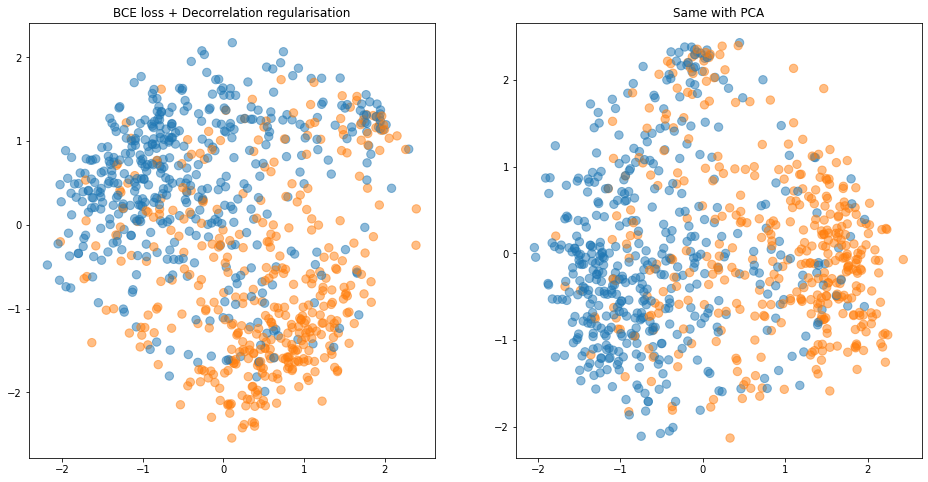

In [27]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(target_embeddings[:, 0], target_embeddings[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

pca = PCA(2)
pca.fit(target_embeddings)
target_pca = np.dot(target_embeddings, pca.components_.T)
axs[1].scatter(target_pca[:, 0], target_pca[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

# axs[0].set_title('Original BCE loss')
axs[0].set_title('BCE loss + Decorrelation regularisation')
# axs[0].set_title('BCE loss + Distance exp regularisation')
# axs[0].set_title('BCE loss + Distance l2 regularisation')
axs[1].set_title('Same with PCA')
plt.show()

In [89]:
def get_line_borders(target_embeddings, w, b):
    x_max, y_max = target_embeddings.max(axis=0)
    x_min, y_min = target_embeddings.min(axis=0)
    
    w = w.detach().cpu().numpy().flatten()
    b = b.detach().cpu().numpy()[0]
    
    borders = []
    y = -(w[0] * x_max + b) / w[1]
    if y_min < y < y_max:
        borders.append((x_max, y))
    y = -(w[0] * x_min + b) / w[1]
    if y_min < y < y_max:
        borders.append((x_min, y))
        
    x = -(w[1] * y_max + b) / w[0]
    if x_min < x < x_max:
        borders.append((x, y_max))
    x = -(w[1] * y_min + b) / w[0]
    if x_min < x < x_max:
        borders.append((x, y_min))

    assert len(borders) == 2
    return list(zip(*borders))

In [151]:
def get_heatmap(ax, target_embeddings, w, b):
    x_max, y_max = target_embeddings.max(axis=0)
    x_min, y_min = target_embeddings.min(axis=0)
    w = w.detach().cpu().numpy().flatten()
    b = b.detach().cpu().numpy()[0]
    
    n = 100
    X = np.linspace(x_min, x_max, n).reshape(1, n).repeat(n, axis=0)
    Y = np.linspace(y_min, y_max, n).reshape(n, 1).repeat(n, axis=1)
    
    Z = (w[0] * X.flatten() + w[1] * Y.flatten() + b).reshape(n, n)
    Z = 1 / (1 + np.exp(-Z))
    ax.contourf(X, Y, Z, cmap='RdBu_r', levels=100, alpha=0.6, antialiased=True)

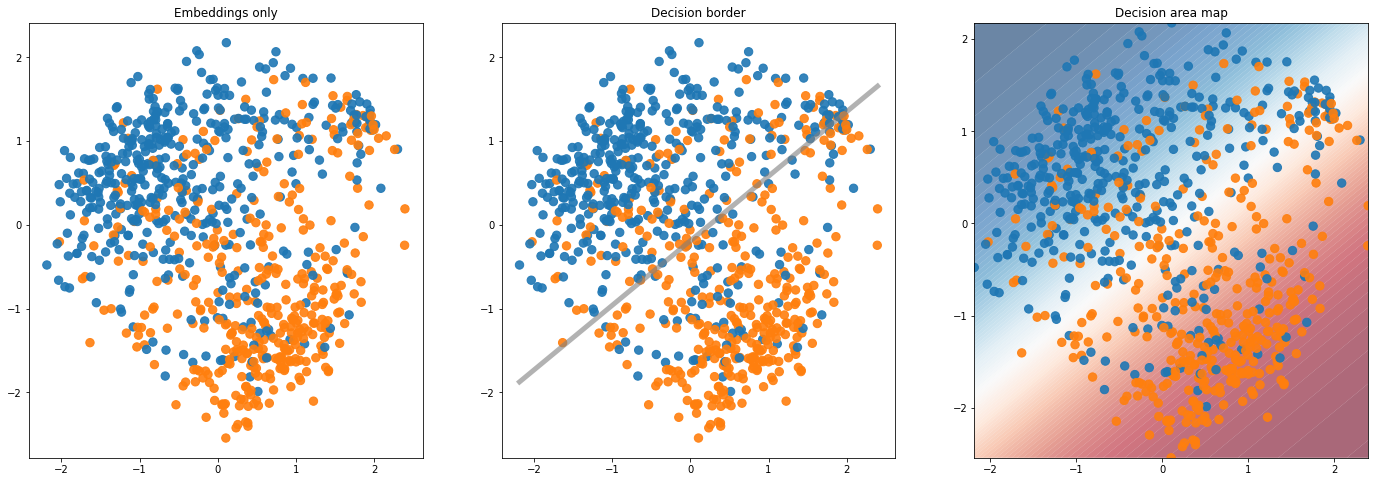

In [156]:
_, axs = plt.subplots(1, 3, figsize=(8 * 3, 8))

axs[1].plot(*get_line_borders(target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias),
           linewidth=5, alpha=0.6, color='gray')
get_heatmap(axs[2], target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias)  

for ax in axs[:3]:
    ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.9, s=70)

axs[0].set_title('Embeddings only')
axs[1].set_title('Decision border')
axs[2].set_title('Decision area map')

plt.show()

In [28]:
l_conf = conf['substitute']

_substitute_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _substitute_trainer_params['logger'] = TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_substitute_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]
substitute_trainer = pl.Trainer(**_substitute_trainer_params)

substitute_model = SequenceToTarget(l_conf['params'])
substitute_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.substitute_files)
substitute_trainer.fit(substitute_model, substitute_dm)

substitute_valid_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in substitute_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-04 12:13:58,946 INFO    setup_map              : Loaded 3797 for train model


0it [00:00, ?it/s]

2021-06-04 12:13:59,002 INFO    setup_map              : Loaded 370 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-04 12:13:59,008 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 145   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.8071, valid_accuracy: 0.7441


In [29]:
substitute_trainer.test(model=substitute_model, test_dataloaders=test_dm.test_dataloader())
substitute_test_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in substitute_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7749999761581421, 'test_auroc': 0.8632344007492065}
--------------------------------------------------------------------------------
test_auroc: 0.8632, test_accuracy: 0.7750


In [30]:
target_valid_metrics, target_test_metrics, substitute_valid_metrics, substitute_test_metrics

({'auroc': 0.8412981629371643, 'accuracy': 0.7750887870788574},
 {'auroc': 0.8578282594680786, 'accuracy': 0.7892857193946838},
 {'auroc': 0.8070823550224304, 'accuracy': 0.7440884709358215},
 {'auroc': 0.8632344007492065, 'accuracy': 0.7749999761581421})

In [32]:
class GreadyAttacker:
    def __init__(self):
        self._src = None

    def __call__(self, src):
        self._src = src
        return iter(self)

    def __iter__(self):
        for i, rec in enumerate(self._src):
            for t in self.process(i, rec):
                yield t

    def process(self, i, x):
        # original record
        rec, y = x
        yield rec, {'id': i, 'y': y, 'new_mcc': None, 'new_mcc_len': 0}
        
        for mcc_len in [1, 2]:
            new_rec = {}
            for k in rec.keys():
                ['amount', 'event_time', 'mcc_code', ]
                if k in ('tr_type',):
                    new_v = 2
                elif k == 'event_time':
                    new_v = rec[k][-1] + 1
                elif k in ('amount',):
                    new_v = rec[k][-1]
                else:
                    continue
                new_rec[k] = torch.cat([rec[k], torch.tensor([new_v] * mcc_len)])

            for new_mcc in product(*[range(2, 100) for _ in range(mcc_len)]):
                _new_rec = {k: v for k, v in new_rec.items()}
                _new_rec['mcc_code'] = torch.cat([rec['mcc_code'], torch.tensor(new_mcc)])
                yield _new_rec, {'id': i, 'y': y, 'new_mcc': new_mcc, 'new_mcc_len': len(new_mcc)}

In [33]:
class AdversarialAttackDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))
        
        yield GreadyAttacker()

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [34]:
attack_dm = AdversarialAttackDataModule(conf['data_module'], target_model, *data_splitter.test_files)
attack_dm.prepare_data()

In [35]:
# list(islice(iter(attack_dm.test_dataloader().dataset), 2))

In [37]:
class AttackTestModel(torch.nn.Module):
    def __init__(self, target_model, substitute_model):
        super().__init__()
        
        self.target_emb_model = torch.nn.Sequential(
            target_model._seq_encoder,
            *target_model._head,
        )
        self.target_head = torch.nn.Sequential(
            *target_model.head2,
        )
        self.substitute_model = substitute_model

    def forward(self, x):
        t_emb = self.target_emb_model(x)
        t_score = self.target_head(t_emb).unsqueeze(-1)
        s_score = self.substitute_model(x).unsqueeze(-1)
        return torch.cat([t_emb, t_score, s_score], dim=1)

attack_test_model = AttackTestModel(target_model, substitute_model)

In [38]:
%%time
ts, original_scores = tuple(score_model2(attack_test_model, attack_dm.test_dataloader(), {'device': 'cuda'}))
for rec, t_x, t_y, t_score, s_score, in zip(original_scores, *ts.T):
    rec['t_x'] = t_x
    rec['t_y'] = t_y
    rec['t_score'] = t_score
    rec['s_score'] = s_score


CPU times: user 9min 37s, sys: 45.8 s, total: 10min 23s
Wall time: 12min 8s


In [39]:
len(original_scores)

8150520

In [40]:
original_scores[95:105]

array([{'id': 0, 'y': 0, 'new_mcc': (96,), 'new_mcc_len': 1, 't_x': -1.0288615, 't_y': 1.2368324, 't_score': 0.07284686, 's_score': 0.05834093},
       {'id': 0, 'y': 0, 'new_mcc': (97,), 'new_mcc_len': 1, 't_x': -1.0952204, 't_y': 1.0691606, 't_score': 0.082397684, 's_score': 0.07048905},
       {'id': 0, 'y': 0, 'new_mcc': (98,), 'new_mcc_len': 1, 't_x': -1.0044045, 't_y': 1.1042061, 't_score': 0.085478604, 's_score': 0.056215916},
       {'id': 0, 'y': 0, 'new_mcc': (99,), 'new_mcc_len': 1, 't_x': -1.1268637, 't_y': 0.88621104, 't_score': 0.097222865, 's_score': 0.065386675},
       {'id': 0, 'y': 0, 'new_mcc': (2, 2), 'new_mcc_len': 2, 't_x': -0.89254266, 't_y': 1.1016898, 't_score': 0.09377283, 's_score': 0.0741934},
       {'id': 0, 'y': 0, 'new_mcc': (2, 3), 'new_mcc_len': 2, 't_x': -0.7689397, 't_y': 1.1555002, 't_score': 0.09789089, 's_score': 0.053096887},
       {'id': 0, 'y': 0, 'new_mcc': (2, 4), 'new_mcc_len': 2, 't_x': -0.6982613, 't_y': 1.3420551, 't_score': 0.08531246,

In [41]:
# check accuracy
np.mean([(rec['t_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_mcc'] is None])

0.7892857142857143

In [42]:
# check accuracy
np.mean([(rec['s_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_mcc'] is None])

0.775

In [43]:
df_test_all = pd.DataFrame(original_scores.tolist())
df_test_orig = df_test_all[lambda x: x['new_mcc'].isna()][['id', 's_score', 't_score', 't_x', 't_y', 'y']] \
    .rename(columns={'s_score': 's_score_orig', 't_score': 't_score_orig', 't_x': 't_x_orig', 't_y': 't_y_orig'})

df_test = pd.merge(
    df_test_all[lambda x: ~x['new_mcc'].isna()],
    df_test_orig.drop(columns='y'),
    on='id',
).assign(s_p_drop=lambda x: x['s_score_orig'] - x['s_score']) \
.assign(t_p_drop=lambda x: x['t_score_orig'] - x['t_score'])

In [44]:
df_test_orig.head()

id  s_score_orig  t_score_orig  t_x_orig  t_y_orig  y
0       0      0.049233      0.089915 -0.867838  1.161090  0
9703    1      0.447656      0.707909  0.841973 -0.312671  0
19406   2      0.896975      0.774926  0.117990 -1.177065  1
29109   3      0.414402      0.925322  0.514363 -1.988802  0
38812   4      0.962710      0.868931  0.844575 -1.188602  1

In [45]:
df_test_orig.sort_values('s_score_orig').iloc[::80]

id  s_score_orig  t_score_orig  t_x_orig  t_y_orig  y
6471901  667      0.009732      0.067444 -1.703531  0.789060  0
4220805  435      0.040387      0.096161 -0.971214  1.016804  0
3706546  382      0.078568      0.103458 -0.784732  1.089666  0
5588928  576      0.147961      0.179490 -0.556956  0.707254  0
7597449  783      0.260793      0.566613  0.049777 -0.384860  1
4890312  504      0.381814      0.223786 -1.233040 -0.054770  0
436635    45      0.488941      0.558981  1.983895  1.133138  0
4143181  427      0.652375      0.647716  1.689011  0.581281  1
853864    88      0.830727      0.778585  0.481267 -0.915442  1
1028518  106      0.935723      0.908088  0.793456 -1.576092  1
4929124  508      0.975828      0.922962  0.423857 -2.029193  1

In [46]:
(df_test_orig['s_score_orig'].ge(0.5) == df_test_orig['y']).mean(), \
(df_test_orig['t_score_orig'].ge(0.5) == df_test_orig['y']).mean()

(0.775, 0.7892857142857143)

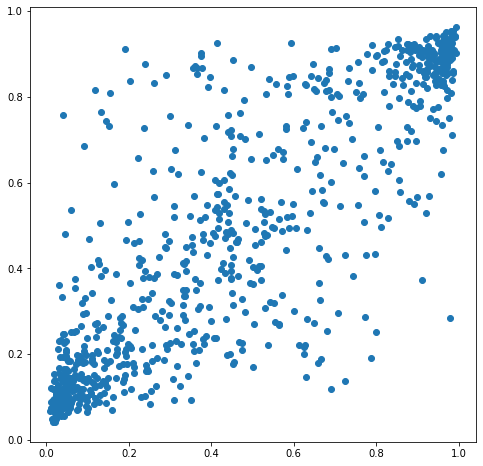

In [47]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test_orig['s_score_orig'], df_test_orig['t_score_orig'])
plt.show()

In [48]:
df_test

id  y   new_mcc  new_mcc_len       t_x       t_y   t_score  \
0          0  0      (2,)            1 -0.962441  1.081172  0.090573   
1          0  0      (3,)            1 -0.848120  1.114395  0.095892   
2          0  0      (4,)            1 -0.762561  1.323046  0.082619   
3          0  0      (5,)            1 -1.538500  0.683505  0.086287   
4          0  0      (6,)            1 -1.184032  0.839010  0.097538   
...      ... ..       ...          ...       ...       ...       ...   
8149675  839  0  (99, 95)            2  0.743522  0.734736  0.400768   
8149676  839  0  (99, 96)            2  0.649783  0.912078  0.334399   
8149677  839  0  (99, 97)            2  0.789689  0.542071  0.464897   
8149678  839  0  (99, 98)            2  0.712438  0.450935  0.473914   
8149679  839  0  (99, 99)            2  0.690604  0.396522  0.484664   

          s_score  s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  \
0        0.065995      0.049233      0.089915 -0.867838  1.161090 -0.016763   
1        0.049559      0.049233      0.089915 -0.867838  1.161090 -0.000326   
2        0.062519      0.049233      0.089915 -0.867838  1.161090 -0.013286   
3        0.055306      0.049233      0.089915 -0.867838  1.161090 -0.006074   
4        0.061365      0.049233      0.089915 -0.867838  1.161090 -0.012132   
...           ...           ...           ...       ...       ...       ...   
8149675  0.671365      0.631093      0.489516  1.533847  1.029601 -0.040272   
8149676  0.480093      0.631093      0.489516  1.533847  1.029601  0.150999   
8149677  0.642404      0.631093      0.489516  1.533847  1.029601 -0.011312   
8149678  0.685422      0.631093      0.489516  1.533847  1.029601 -0.054329   
8149679  0.692721      0.631093      0.489516  1.533847  1.029601 -0.061628   

         t_p_drop  
0       -0.000658  
1       -0.005977  
2        0.007296  
3        0.003628  
4       -0.007623  
...           ...  
8149675  0.088747  
8149676  0.155117  
8149677  0.024618  
8149678  0.015602  
8149679  0.004851  

[8149680 rows x 14 columns]

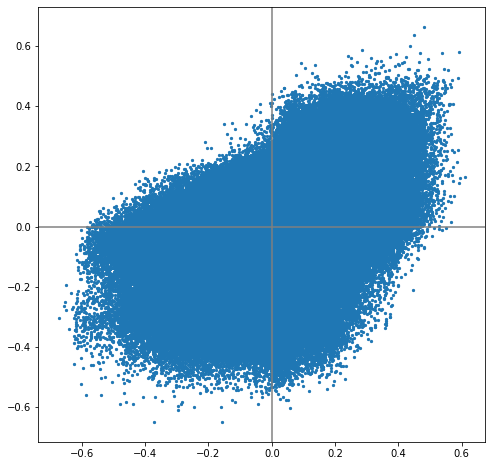

In [49]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test['s_p_drop'], df_test['t_p_drop'], s=5)
plt.axvline(0, color='gray')
plt.axhline(0, color='gray')
plt.show()

In [51]:
for _id in [37]:
    print('id', _id)
    display(df_test[lambda x: x['id'].eq(_id)].sort_values('s_p_drop', ascending=False).iloc[::1000])
    display(df_test[lambda x: x['id'].eq(_id)].sort_values('new_mcc', ascending=True).iloc[::1000])

id 37


id  y   new_mcc  new_mcc_len       t_x       t_y   t_score   s_score  \
364017  37  0  (52, 47)            2 -0.797463  1.101533  0.101176  0.136793   
361851  37  0  (30, 37)            2 -0.174809  1.339382  0.129352  0.368935   
361756  37  0  (29, 40)            2  0.333975  1.020633  0.251277  0.435703   
361964  37  0  (31, 52)            2 -0.016738  0.854905  0.229395  0.477981   
360124  37  0  (12, 74)            2 -0.016357  1.000314  0.201320  0.507126   
367700  37  0   (90, 6)            2  0.029228  0.906402  0.226156  0.531917   
364085  37  0  (53, 17)            2  0.318017  0.928041  0.268984  0.554940   
366895  37  0  (81, 83)            2  0.165004  0.976442  0.233177  0.578199   
365950  37  0  (72, 20)            2  0.512311  0.573924  0.395983  0.609193   
368109  37  0  (94, 23)            2 -0.293151  0.880249  0.184672  0.664163   

        s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
364017      0.537858      0.221233  1.089653  1.748577  0.401064  0.120057  
361851      0.537858      0.221233  1.089653  1.748577  0.168923  0.091881  
361756      0.537858      0.221233  1.089653  1.748577  0.102154 -0.030044  
361964      0.537858      0.221233  1.089653  1.748577  0.059877 -0.008162  
360124      0.537858      0.221233  1.089653  1.748577  0.030731  0.019912  
367700      0.537858      0.221233  1.089653  1.748577  0.005940 -0.004923  
364085      0.537858      0.221233  1.089653  1.748577 -0.017082 -0.047751  
366895      0.537858      0.221233  1.089653  1.748577 -0.040341 -0.011944  
365950      0.537858      0.221233  1.089653  1.748577 -0.071335 -0.174750  
368109      0.537858      0.221233  1.089653  1.748577 -0.126305  0.036561

id  y   new_mcc  new_mcc_len       t_x       t_y   t_score   s_score  \
358974  37  0      (2,)            1  0.906393  1.602778  0.222129  0.564858   
360061  37  0  (12, 11)            2  0.259685  0.792676  0.289838  0.537502   
361051  37  0  (22, 21)            2  0.168382  1.244450  0.183223  0.283570   
362041  37  0  (32, 31)            2  0.582637  0.895947  0.325372  0.516368   
363031  37  0  (42, 41)            2  0.326517  0.884506  0.280421  0.591717   
364021  37  0  (52, 51)            2  0.059710  0.922236  0.227697  0.324353   
365011  37  0  (62, 61)            2 -0.228480  0.556217  0.257986  0.625168   
366001  37  0  (72, 71)            2  0.529368  0.765765  0.348180  0.525158   
366991  37  0  (82, 81)            2  0.107790  1.053859  0.209202  0.549689   
367981  37  0  (92, 91)            2  0.068004  0.985988  0.216343  0.541595   

        s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
358974      0.537858      0.221233  1.089653  1.748577 -0.027001 -0.000896  
360061      0.537858      0.221233  1.089653  1.748577  0.000355 -0.068605  
361051      0.537858      0.221233  1.089653  1.748577  0.254287  0.038010  
362041      0.537858      0.221233  1.089653  1.748577  0.021490 -0.104139  
363031      0.537858      0.221233  1.089653  1.748577 -0.053860 -0.059188  
364021      0.537858      0.221233  1.089653  1.748577  0.213504 -0.006464  
365011      0.537858      0.221233  1.089653  1.748577 -0.087310 -0.036753  
366001      0.537858      0.221233  1.089653  1.748577  0.012700 -0.126948  
366991      0.537858      0.221233  1.089653  1.748577 -0.011832  0.012031  
367981      0.537858      0.221233  1.089653  1.748577 -0.003737  0.004889

In [52]:
df_best_attacks = df_test.groupby('id').apply(lambda x: x.sort_values('s_p_drop', ascending=False).iloc[0])
df_best_attacks

id  y   new_mcc  new_mcc_len       t_x       t_y   t_score   s_score  \
id                                                                           
0      0  0  (52, 52)            2 -1.127407  1.001818  0.086159  0.032199   
1      1  0  (47, 47)            2 -1.079021  0.202586  0.197399  0.112732   
2      2  1  (47, 30)            2 -0.434294 -0.899117  0.605822  0.657446   
3      3  0  (52, 47)            2  0.066596 -1.732194  0.861429  0.232686   
4      4  1   (47, 7)            2  0.395623 -1.311666  0.836979  0.945024   
..   ... ..       ...          ...       ...       ...       ...       ...   
835  835  1  (16, 47)            2 -0.343414 -0.818559  0.602943  0.882507   
836  836  0  (47, 24)            2 -0.664714  0.687931  0.168981  0.086619   
837  837  0  (47, 66)            2 -0.381962  0.325620  0.283379  0.063844   
838  838  0  (52, 52)            2 -1.400786  0.468356  0.120093  0.081043   
839  839  0  (47, 16)            2  0.073882  1.209103  0.176878  0.087434   

     s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
id                                                                       
0        0.049233      0.089915 -0.867838  1.161090  0.017033  0.003756  
1        0.447656      0.707909  0.841973 -0.312671  0.334923  0.510511  
2        0.896975      0.774926  0.117990 -1.177065  0.239530  0.169104  
3        0.414402      0.925322  0.514363 -1.988802  0.181716  0.063893  
4        0.962710      0.868931  0.844575 -1.188602  0.017685  0.031952  
..            ...           ...       ...       ...       ...       ...  
835      0.950606      0.775366  0.100475 -1.192772  0.068099  0.172423  
836      0.355328      0.437277 -0.020143  0.015150  0.268709  0.268297  
837      0.409324      0.606668  1.830649  0.843741  0.345480  0.323290  
838      0.109749      0.133659 -1.597513  0.209775  0.028706  0.013566  
839      0.631093      0.489516  1.533847  1.029601  0.543659  0.312638  

[840 rows x 14 columns]

In [53]:
# mean p_drop
df_best_attacks['t_p_drop'].mean()

0.11745287512562104

In [54]:
# new accuracy
df_best_attacks.assign(t_new_acc=lambda x: x['t_score'].ge(0.5) == x['y'])['t_new_acc'].mean()

0.736904761904762

In [55]:
# original confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score_orig'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y         0    1
t_pred          
0       366   97
1        80  297

In [56]:
# new confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y         0    1
t_pred          
0       397  172
1        49  222

In [57]:
# top attack mcc
df_best_attacks['new_mcc'].value_counts()

(52, 47)    183
(52, 52)    125
(47, 47)     60
(47, 16)     58
(16, 47)     58
(52, 24)     44
(47, 30)     42
(47, 66)     29
(66, 16)     28
(47, 52)     23
(39, 24)     18
(39, 52)     17
(52, 39)     15
(2, 47)      14
(66, 24)     13
(16, 7)      12
(66, 47)     11
(47, 7)      11
(7, 47)      10
(52, 30)     10
(52, 16)      8
(24, 30)      8
(32, 24)      7
(24, 47)      6
(52, 66)      4
(47, 24)      3
(24, 16)      3
(16, 32)      3
(24, 52)      3
(16, 16)      3
(39, 30)      3
(16, 52)      2
(2, 16)       2
(9, 16)       1
(7, 16)       1
(24, 32)      1
(39, 47)      1
Name: new_mcc, dtype: int64

# Ищем примеры

Подбираем разные примеры:
- разные примеры по эффективности атаки (разные по диапазону t_p_drop)
- разные по сложности (по исходной вероятности класса)

In [157]:
for col in ['t_score_orig', 't_p_drop']:
    df_best_attacks[f'{col}_bin'] = pd.cut(
        df_best_attacks[col],
        df_best_attacks[col].quantile([0, 0.25, 0.5, 0.75, 1]).values,
        labels=range(4),
    ).fillna(0)

In [159]:
def plot_example(_id, suptitle):
    _, axs = plt.subplots(1, 3, figsize=(6 * 3, 6))

    for ax in axs:
        ax.plot(*get_line_borders(
            target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias),
            linewidth=5, alpha=0.6, color='gray')

        ax.scatter(
            df_test_orig['t_x_orig'], 
            df_test_orig['t_y_orig'],
            c=df_test_orig['y'].apply(plt.get_cmap('tab10')), alpha=0.5
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(_id)]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(_id)]['t_y_orig'],
            c='black', marker='*', s=600,
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(_id)]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(_id)]['t_y_orig'],
            c='green', marker='*', s=400,
        )

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sort_values('new_mcc').iloc[[0]]
    axs[0].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[0].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[0].set_title(f'Most popular: {df["new_mcc"].values[0]}')

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sample(n=1)
    axs[1].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[1].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[1].set_title(f'Random: {df["new_mcc"].values[0]}')

    df = df_test[lambda x: x['id'].eq(_id) & x['new_mcc_len'].eq(2)].sort_values('s_p_drop', ascending=False).iloc[[0]]
    axs[2].scatter(df['t_x'], df['t_y'], c='black', marker='*', s=600)
    axs[2].scatter(df['t_x'], df['t_y'], c='red', marker='*', s=400)
    axs[2].set_title(f'Most adversarial: {df["new_mcc"].values[0]}')

    plt.suptitle(suptitle)
    plt.show()

In [164]:
df_best_attacks.groupby(['y', 't_score_orig_bin', 't_p_drop_bin']).apply(lambda x: x.sample(n=2)).loc[[1]] \
    [['id', 'y', 'new_mcc', 'new_mcc_len', 's_p_drop', 't_score_orig', 't_score', 't_p_drop']]

id  y   new_mcc  new_mcc_len  s_p_drop  \
y t_score_orig_bin t_p_drop_bin id                                             
1 0                0            29    29  1  (52, 52)            2  0.017799   
                                543  543  1  (47, 52)            2  0.042779   
                   1            631  631  1  (52, 47)            2  0.027440   
                                5      5  1  (52, 47)            2  0.050774   
  1                0            528  528  1  (66, 24)            2  0.276870   
                                421  421  1  (52, 39)            2  0.131909   
                   1            358  358  1  (52, 24)            2  0.332438   
                                583  583  1  (47, 30)            2  0.134819   
                   2            441  441  1  (52, 24)            2  0.093528   
                                401  401  1  (52, 47)            2  0.299322   
                   3            578  578  1  (16, 47)            2  0.157775   
                                428  428  1  (47, 16)            2  0.290523   
  2                0            477  477  1  (52, 66)            2  0.489375   
                                595  595  1  (66, 16)            2  0.425584   
                   1            546  546  1  (47, 30)            2  0.115937   
                                30    30  1  (66, 16)            2  0.351671   
                   2            778  778  1  (52, 16)            2  0.142416   
                                337  337  1  (47, 66)            2  0.387736   
                   3            94    94  1  (52, 47)            2  0.229433   
                                561  561  1  (47, 16)            2  0.362223   
  3                0            309  309  1   (16, 7)            2  0.043745   
                                697  697  1  (66, 16)            2  0.048870   
                   1            278  278  1  (16, 47)            2  0.034678   
                                777  777  1  (16, 47)            2  0.048486   
                   2            204  204  1  (47, 30)            2  0.199255   
                                71    71  1   (2, 47)            2  0.188504   
                   3            478  478  1  (47, 16)            2  0.087731   
                                117  117  1  (47, 66)            2  0.550472   

                                     t_score_orig   t_score  t_p_drop  
y t_score_orig_bin t_p_drop_bin id                                     
1 0                0            29       0.059733  0.064915 -0.005182  
                                543      0.098638  0.072335  0.026302  
                   1            631      0.144925  0.107186  0.037740  
                                5        0.134285  0.092682  0.041603  
  1                0            528      0.318637  0.350638 -0.032001  
                                421      0.272747  0.247719  0.025028  
                   1            358      0.210271  0.139848  0.070423  
                                583      0.251629  0.166667  0.084962  
                   2            441      0.256463  0.136663  0.119801  
                                401      0.236974  0.103889  0.133084  
                   3            578      0.327728  0.118450  0.209277  
                                428      0.392463  0.143655  0.248807  
  2                0            477      0.552308  0.534104  0.018204  
                                595      0.516909  0.503458  0.013451  
                   1            546      0.738434  0.666373  0.072061  
                                30       0.814620  0.749251  0.065369  
                   2            778      0.790706  0.659769  0.130937  
                                337      0.522077  0.366857  0.155220  
                   3            94       0.464432  0.126347  0.338085  
                                561      0.542210  0.207877  0.334333  
  3                0            309      0.856558  0.

In [168]:
df_best_attacks[lambda x: x['t_score_orig'].ge(0.6) & x['t_score'].lt(0.4)]

id  y   new_mcc  new_mcc_len       t_x       t_y   t_score   s_score  \
id                                                                           
1      1  0  (47, 47)            2 -1.079021  0.202586  0.197399  0.112732   
16    16  1  (47, 47)            2 -0.693645  0.197193  0.258084  0.724871   
23    23  1  (16, 47)            2 -0.875979 -0.228015  0.325265  0.434926   
34    34  1  (47, 66)            2 -0.406491 -0.135406  0.396275  0.260710   
47    47  0  (47, 47)            2 -1.104995 -0.523129  0.355770  0.728333   
132  132  1  (16, 47)            2 -0.413667  0.747156  0.191710  0.057528   
143  143  1  (16, 47)            2 -0.283376  0.020682  0.379625  0.890013   
157  157  1  (47, 47)            2 -0.930072  0.319760  0.196971  0.076022   
202  202  1  (47, 16)            2 -0.286721  0.236733  0.322626  0.425721   
219  219  0  (52, 47)            2 -0.601431  0.567252  0.198033  0.076573   
223  223  0  (47, 47)            2 -1.067521  0.190222  0.201282  0.103371   
224  224  0  (52, 47)            2 -0.513567 -0.136407  0.374146  0.030980   
236  236  1  (47, 66)            2 -0.237075  0.476037  0.274451  0.127519   
253  253  0  (47, 66)            2 -0.137555  0.094051  0.390218  0.063812   
272  272  1  (16, 47)            2 -0.879821 -0.302905  0.343612  0.592589   
296  296  0  (47, 47)            2 -1.002104 -0.275318  0.312834  0.196856   
351  351  1  (47, 47)            2 -0.621418 -0.232238  0.377558  0.127350   
390  390  1  (47, 16)            2 -0.354364 -0.000669  0.370659  0.542367   
403  403  1  (47, 66)            2 -0.308145  0.407209  0.277668  0.055658   
414  414  0  (47, 47)            2 -0.458228  0.689354  0.195910  0.048482   
427  427  1  (52, 47)            2 -0.635876  0.626554  0.182868  0.086716   
555  555  0  (16, 47)            2 -0.680191 -0.120019  0.336155  0.687058   
565  565  0  (47, 47)            2 -0.838713 -0.281926  0.346386  0.181181   
566  566  1  (47, 47)            2 -0.826538 -0.157095  0.317066  0.360640   
592  592  0  (47, 30)            2 -0.697734 -0.259228  0.369022  0.160577   
666  666  1  (47, 66)            2  0.060535  0.267199  0.384656  0.102537   
722  722  1  (47, 16)            2 -0.429056  0.230139  0.297353  0.513414   
769  769  1  (52, 47)            2 -0.577618 -0.271147  0.397324  0.133945   
788  788  1  (52, 47)            2 -0.799520  0.222057  0.235413  0.249281   
794  794  1  (47, 47)            2 -0.778151  0.102337  0.264659  0.156194   
833  833  1  (47, 47)            2 -0.535926  0.419993  0.236499  0.533799   
837  837  0  (47, 66)            2 -0.381962  0.325620  0.283379  0.063844   

     s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  \
id                                                                        
1        0.447656      0.707909  0.841973 -0.312671  0.334923  0.510511   
16       0.957209      0.619035  1.034012  0.184168  0.232338  0.360951   
23       0.732295      0.837291  0.589316 -1.164354  0.297369  0.512026   
34       0.606722      0.632158  0.812779 -0.035255  0.346012  0.235883   
47       0.883791      0.720996 -0.166675 -1.146168  0.155457  0.365226   
132      0.382743      0.702886  1.789169  0.438574  0.325215  0.511176   
143      0.963695      0.825794  1.096187 -0.701998  0.073683  0.446169   
157      0.258150      0.626380  0.654490 -0.135666  0.182128  0.429409   
202      0.828047      0.626397  0.565852 -0.204055  0.402327  0.303771   
219      0.374190      0.624727  1.783187  0.740557  0.297616  0.426694   
223      0.430942      0.605029  0.418692 -0.238691  0.327571  0.403747   
224      0.131329      0.764949  1.159608 -0.324978  0.100349  0.390803   
236      0.689310      0.602350  2.057641  1.034478  0.561791  0.327899   
253      0.453190      0.677462  1.781073  0.536109  0.389378  0.287244   
272      0.757632      0.633659 -0.514964 -1.064396  0.165044  0.290047   
296      0.573290      0.655403  0.153068 -0.632258  0.376434  0.342569   
351

In [177]:
selected_ids = [
    (143, 'Успешная атака на сильно уверенный класс'),
    (328, 'Хорошая атака на сильно уверенный класс'),
    (508, 'Слабая атака на сильно уверенный класс'),
    (97, 'Очень слабая атака на сильно уверенный класс'),

    (561, 'Успешная атака на слабо уверенный класс'),
    (137, 'Хорошая атака на слабо уверенный класс'),
    (30, 'Слабая атака на слабо уверенный класс'),
    (407, 'Очень слабая атака на слабо уверенный класс'),

    (416, 'Успешная атака на неуверенный класс'),
    (27, 'Хорошая атака на неуверенный класс'),
    (251, 'Слабая атака на неуверенный класс'),
    (528, 'Очень слабая атака на неуверенный класс'),

    (653, 'Слабая атака на сильно неуверенный класс'),
    (210, 'Очень слабая атака на сильно неуверенный класс'),
]

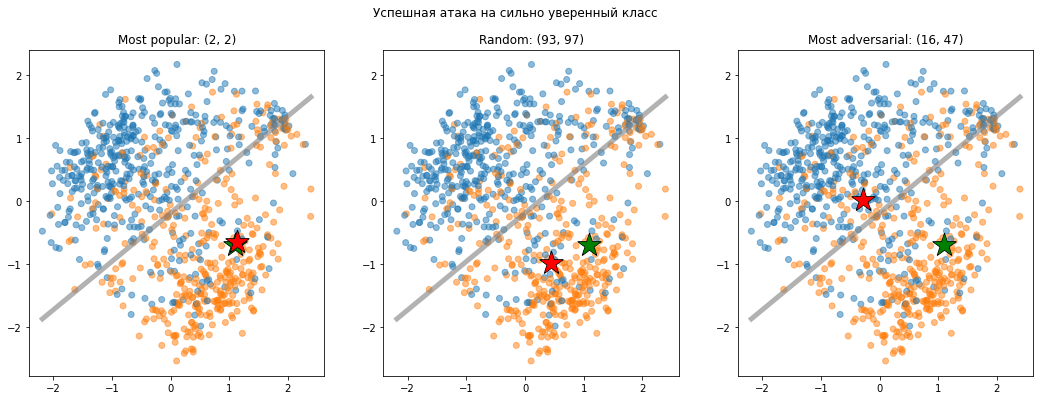

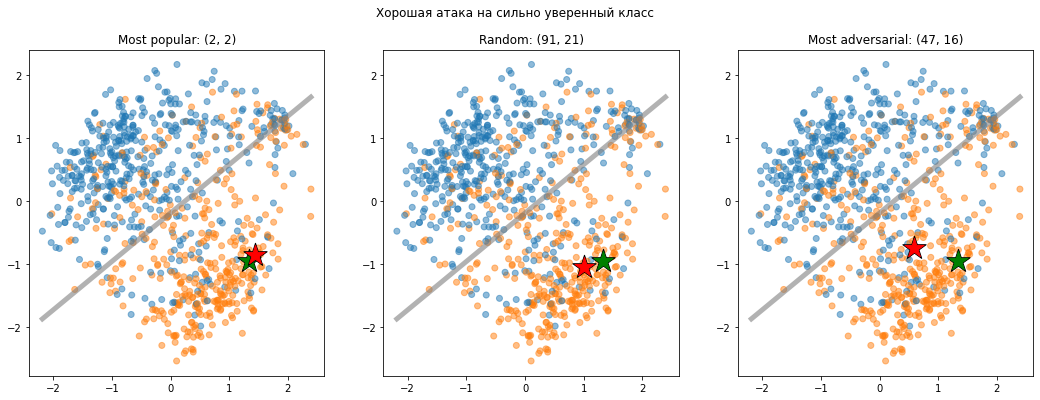

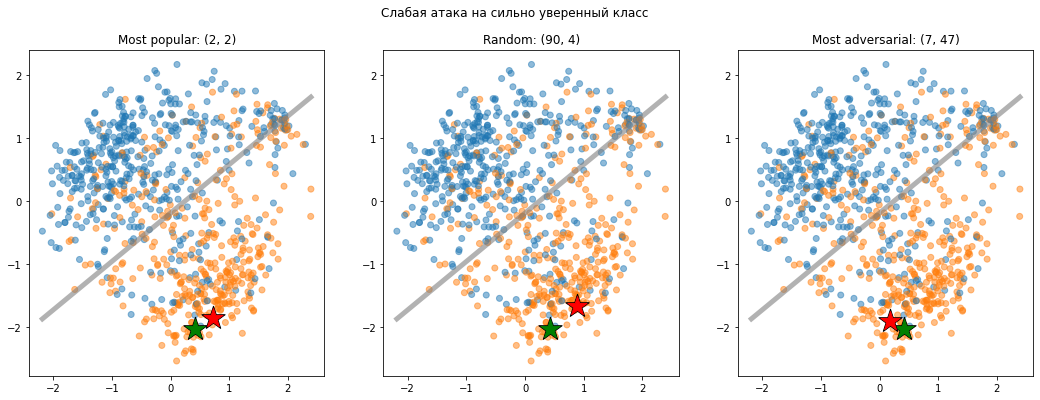

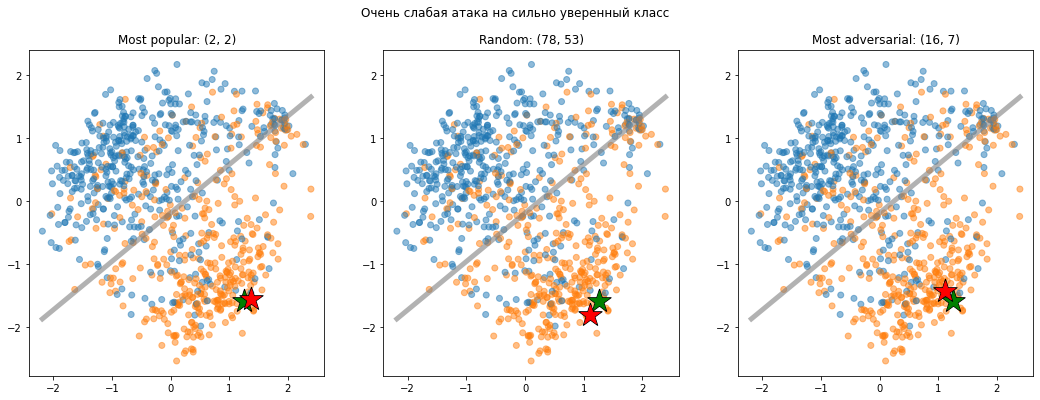

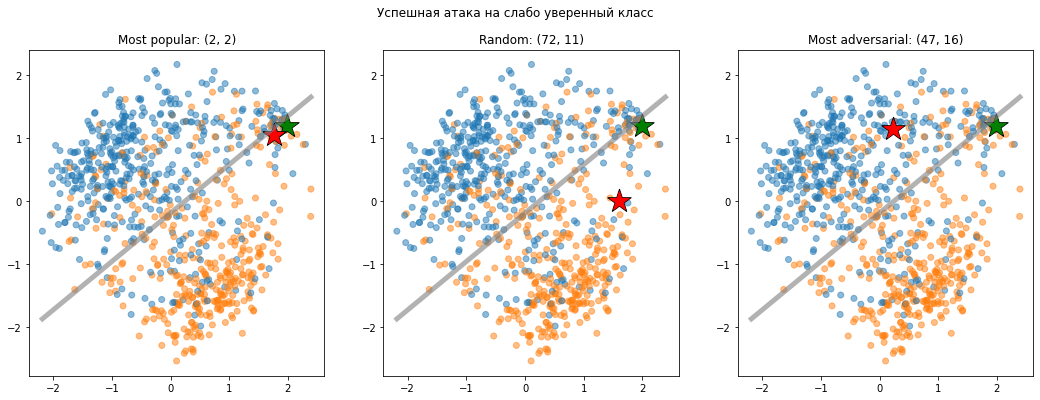

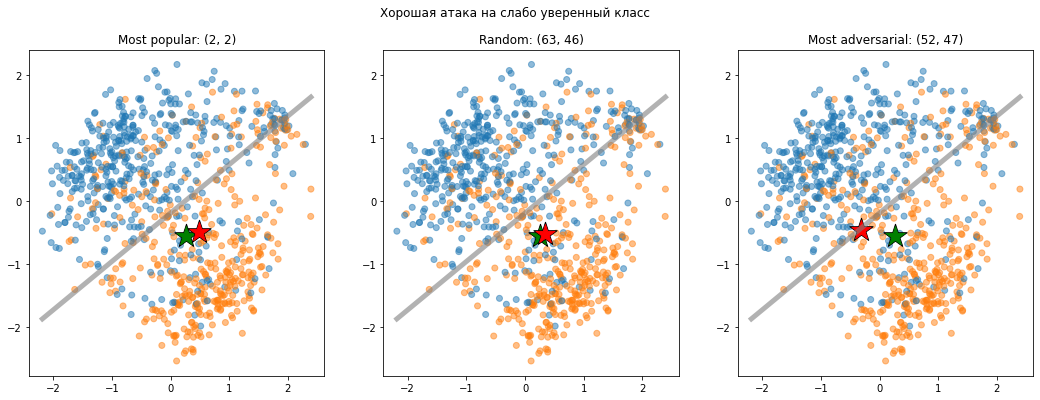

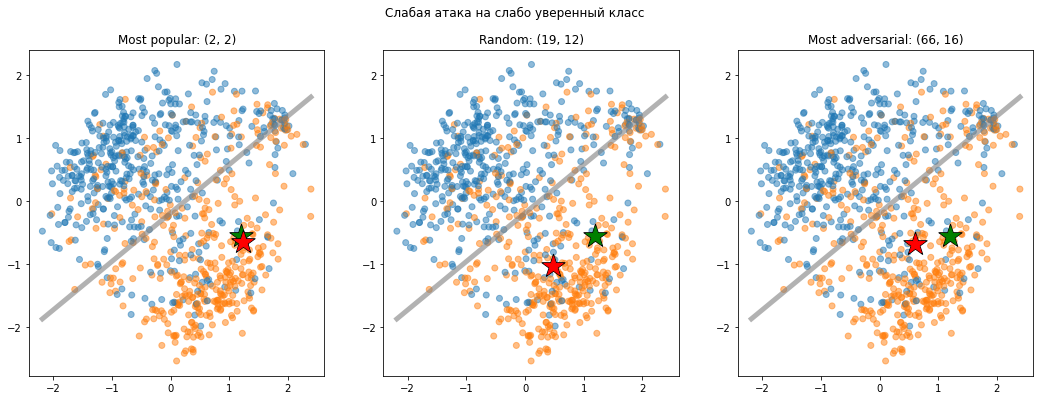

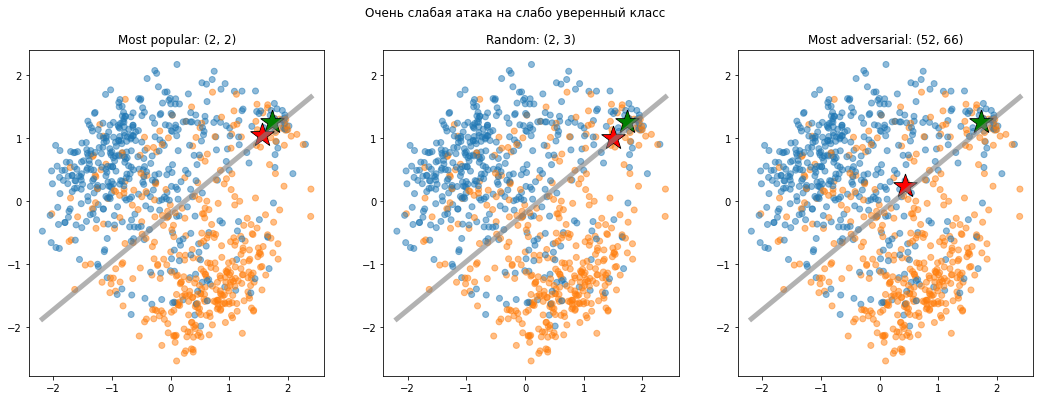

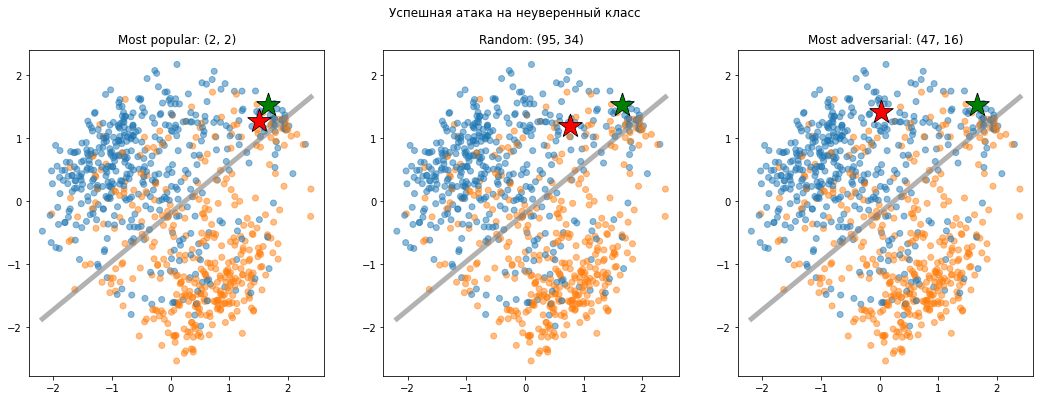

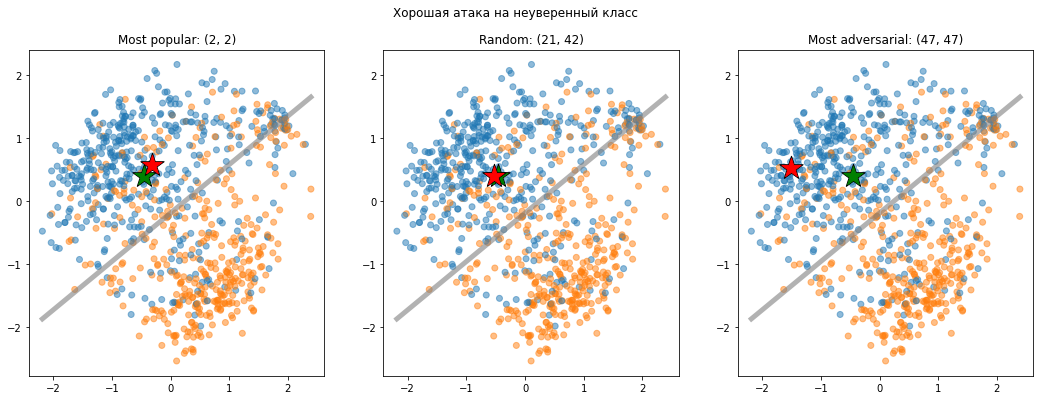

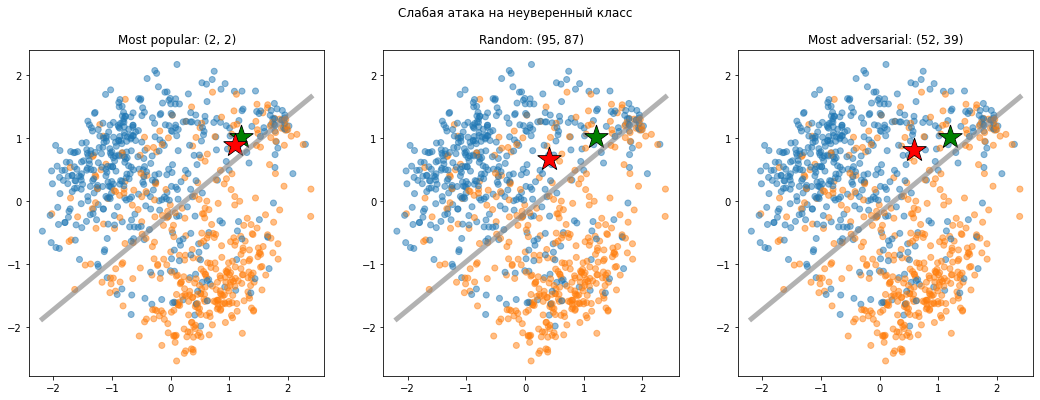

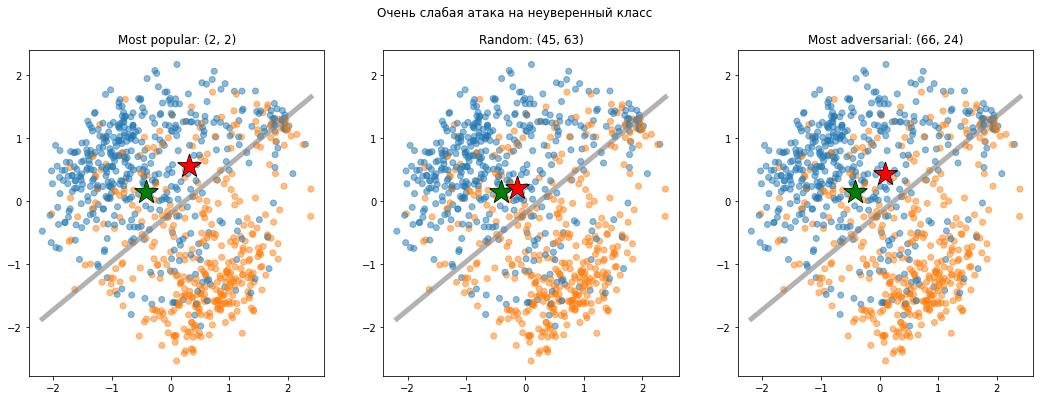

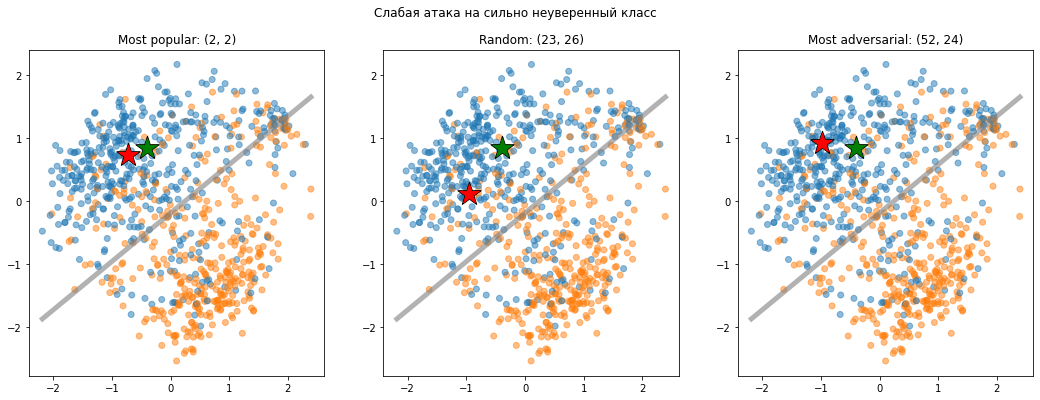

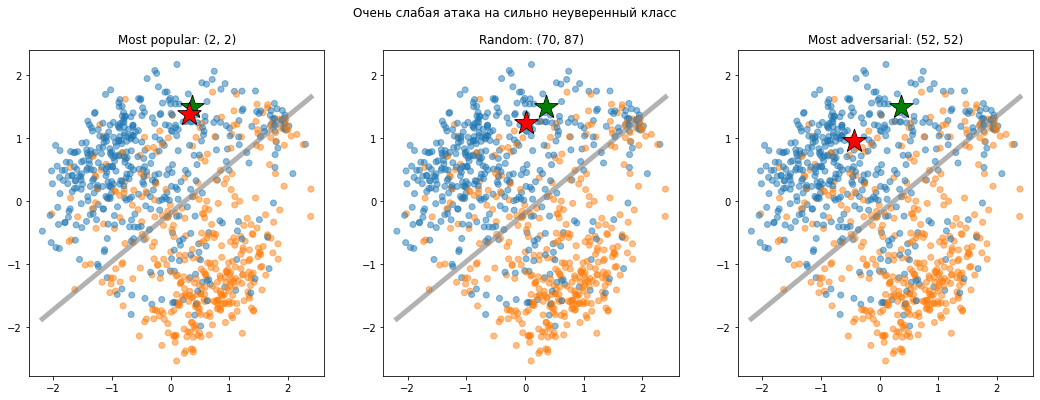

In [178]:
for p in selected_ids:
    plot_example(*p)

    

In [170]:
for trx in attack_dm.test_dataloader().dataset:
    print(trx)
    if trx[1]['new_mcc'] is not None:
        continue
    break

({'amount': tensor([ -9.0057, -12.1942,  -9.3656,  -8.4349, -10.6873, -10.2224,  -9.6628,
         -8.4102,  -7.1198, -11.5090,  -8.7937,  -7.5442,  -9.5948,  -8.4825,
         -8.4052, -11.8600,  11.8600,  -8.1226,  -8.4067,  -8.3082,  -9.0512,
         -9.7451, -10.5848,  -9.2856, -10.0931,  -9.4175, -10.7101,  10.0683,
        -12.3220,  11.8112,  -9.2210,   7.7173,  -9.1038,  -8.8170,  11.6289,
         -9.2069,  -8.7855,  -8.1058,  -8.6883,  -9.3903,  -8.6119,  -9.3264,
         -8.6639, -11.1181,  -9.3264,  12.5127,  -9.2210,  12.5044,  -7.7173,
         -9.6628,  -8.2234,  -8.8113, -10.7988,  -9.2321,  -9.1521,  -9.2654,
         -9.5792,  -9.0059, -10.0195,  -9.4162, -10.2819,  13.6331,  11.8277,
         11.7059,  -8.4062, -12.3708,  11.9654, -11.0842,  12.7473,  -9.9141,
         -9.5670, -10.0195, -10.5670,  -8.5664,  -9.7922,  11.8277,  -9.6914,
         -9.2985,  -9.3264,  -7.2068,  -9.0064, -10.0983,  -9.5383,  -9.1686,
         -8.5160,  10.4249, -10.4249,   9.9141,  11.

# Export

In [171]:
import jsonlines

In [172]:
%%time
with jsonlines.open('original_scores.jsonl', 'w') as f:
    for rec in df_test_orig[['id', 't_score_orig', 't_x_orig', 't_y_orig', 'y']] \
        .assign(t_score_orig=lambda x: np.round(x['t_score_orig'], 3)) \
        .assign(t_x_orig=lambda x: np.round(x['t_x_orig'], 2)) \
        .assign(t_y_orig=lambda x: np.round(x['t_y_orig'], 2)) \
        .to_dict(orient='records'):
        f.write(rec)

CPU times: user 13.3 ms, sys: 206 µs, total: 13.5 ms
Wall time: 14.5 ms


In [173]:
!wc -l original_scores.jsonl
!ls -lh original_scores.jsonl
!head -n 3 original_scores.jsonl

840 original_scores.jsonl
-rw-r--r-- 1 ivan sudo 66K Jun  4 14:15 original_scores.jsonl
{"id": 0, "t_score_orig": 0.09, "t_x_orig": -0.87, "t_y_orig": 1.16, "y": 0}
{"id": 1, "t_score_orig": 0.708, "t_x_orig": 0.84, "t_y_orig": -0.31, "y": 0}
{"id": 2, "t_score_orig": 0.775, "t_x_orig": 0.12, "t_y_orig": -1.18, "y": 1}


In [179]:
%%time
with jsonlines.open('selected_trx.jsonl', 'w') as f:
    for trx in attack_dm.test_dataloader().dataset:
        if trx[1]['new_mcc'] is not None:
            continue
        if trx[1]['id'] not in [x[0] for x in selected_ids]:
            continue
    
        rec = trx[1]
        rec['trx'] = {k: v.numpy() for k, v in trx[0].items()}
        rec['trx']['amount'] = np.round(rec['trx']['amount'], 2)
        rec['trx']['event_time'] = np.round(rec['trx']['event_time'], 2)
        rec['trx'] = {k: v.tolist() for k, v in rec['trx'].items()}
        
        f.write(rec)

CPU times: user 1min 59s, sys: 310 ms, total: 1min 59s
Wall time: 1min 59s


In [180]:
!wc -l selected_trx.jsonl
!ls -lh selected_trx.jsonl
!head -n 2 selected_trx.jsonl

14 selected_trx.jsonl
-rw-r--r-- 1 ivan sudo 82K Jun  4 14:20 selected_trx.jsonl
{"id": 27, "y": 1, "new_mcc": null, "new_mcc_len": 0, "trx": {"amount": [12.73, -12.73, 13.02, -13.02, 13.78, -13.76, 12.44, -12.42, 12.32, -12.32, 11.81, -11.81, -9.66, 12.79, -12.79, 10.02, 11.12, -9.91, -11.12, 12.73, -12.73, 11.63, -11.63, 12.76, -12.76, 13.72, -13.71, 12.1, -12.1, 11.63, -12.32, 15.45, 9.77, -15.36, -8.78, -13.06, 12.73, 14.4, 13.42, 9.8, -14.85, 13.93, -13.93, -10.2, -9.1, 13.86, 13.93, -12.32, 13.75, -12.73, -14.28, -13.76, 12.73, -12.73, 14.01, 13.93, 12.5, 13.43, 13.65, -15.03, -13.55, 13.19, -13.2, 13.71, 12.32, 14.52, 14.3, 13.41, -14.4, -12.32, -14.96, 12.5, 9.29, 13.3, 12.64, -12.5, 14.92, -14.76, 11.97, 13.36, -14.62, 12.98, -13.34, 11.97, 11.89, -12.61, 13.44, 7.72, 13.91, -14.39, -13.45, 11.12, 13.44, 13.56, -14.24, 12.4, 12.75, 12.1, -12.91, 12.1, 11.12, -13.32, 12.64, -11.12, 12.1, 12.06, 11.81, -13.42, -10.71, 11.44, 12.32, -12.73, 12.1, 12.06, -12.73, 11.63, -11.63, 12.

In [181]:
%%time
with jsonlines.open('selected_attacks.jsonl', 'w') as f:
    for rec in df_test[lambda x: x['id'].isin([x[0] for x in selected_ids])].round(3).to_dict(orient='records'):
        f.write(rec)

CPU times: user 2.66 s, sys: 148 ms, total: 2.81 s
Wall time: 2.98 s


In [182]:
!wc -l selected_attacks.jsonl
!ls -lh selected_attacks.jsonl
!head -n 2 selected_attacks.jsonl

135828 selected_attacks.jsonl
-rw-r--r-- 1 ivan sudo 32M Jun  4 14:20 selected_attacks.jsonl
{"id": 27, "y": 1, "new_mcc": [2], "new_mcc_len": 1, "t_x": -0.413, "t_y": 0.515, "t_score": 0.236, "s_score": 0.689, "s_score_orig": 0.68, "t_score_orig": 0.253, "t_x_orig": -0.458, "t_y_orig": 0.403, "s_p_drop": -0.009, "t_p_drop": 0.016}
{"id": 27, "y": 1, "new_mcc": [3], "new_mcc_len": 1, "t_x": -0.191, "t_y": 0.503, "t_score": 0.276, "s_score": 0.708, "s_score_orig": 0.68, "t_score_orig": 0.253, "t_x_orig": -0.458, "t_y_orig": 0.403, "s_p_drop": -0.027, "t_p_drop": -0.024}


# Примеры для дизайнера

In [183]:
print(f'Разберем пример {selected_ids[0][0]}: {selected_ids[0][1]}')

Разберем пример 143: Успешная атака на сильно уверенный класс


In [190]:
with jsonlines.open('selected_trx.jsonl') as f:
    while True:
        data = f.read()
        if data['id'] == selected_ids[0][0]:
            break

In [201]:
trx_data = pd.DataFrame(data['trx'])

trx_data['amount'] = np.round(-1 * np.exp(abs(trx_data['amount'])) * np.sign(trx_data['amount']), 2)

In [204]:
!ls data/*.csv

data/gender_test_kaggle_sample_submission.csv  data/tr_mcc_codes.csv
data/gender_train.csv			       data/tr_types.csv
data/test_ids.csv			       data/transactions.csv


In [228]:
mcc_dict = pd.merge(
    pd.read_csv('data/transactions.csv')['mcc_code'].value_counts(),
    pd.read_csv('data/tr_mcc_codes.csv', sep=';').set_index('mcc_code'),
    left_index=True, right_index=True,
)

mcc_dict = mcc_dict.drop(columns='mcc_code').reset_index()
mcc_dict['mcc_description'] = mcc_dict['index'].astype(str) + ": " + mcc_dict['mcc_description']
mcc_dict.index = range(2, 2 + len(mcc_dict))

mcc_dict = mcc_dict['mcc_description'].to_dict()

In [231]:
trx_data['mcc_code'] = trx_data['mcc_code'].map(mcc_dict).fillna('0000:')

In [242]:
type_dict = pd.merge(
    pd.read_csv('data/transactions.csv')['tr_type'].value_counts(),
    pd.read_csv('data/tr_types.csv', sep=';').set_index('tr_type'),
    left_index=True, right_index=True,
)

In [244]:
type_dict = type_dict.drop(columns='tr_type').reset_index()
type_dict.index = range(2, 2 + len(type_dict))
type_dict = type_dict['tr_description'].to_dict()

In [249]:
trx_data['tr_type'] = trx_data['tr_type'].map(type_dict).fillna('0')

In [260]:
df_hist = trx_data.sort_values('event_time')[['mcc_code', 'tr_type', 'amount']]
df_hist

mcc_code  \
0                        5541: Станции техобслуживания   
1                              5993: Табачные магазины   
2         5812: Места общественного питания, рестораны   
3    5499: Различные продовольственные магазины — р...   
4    5499: Различные продовольственные магазины — р...   
..                                                 ...   
165  6011: Финансовые институты — снятие наличности...   
176  5499: Различные продовольственные магазины — р...   
177                    5251: Скобяные товары в розницу   
178  5733: Продажа музыкальных инструментов, фортеп...   
179                            7523: Паркинги и гаражи   

                                         tr_type     amount  
0                      Покупка. POS  Зарубеж. ТУ   19930.37  
1                      Покупка. POS  Зарубеж. ТУ  100709.96  
2                      Покупка. POS  Зарубеж. ТУ  104820.01  
3                      Покупка. POS  Зарубеж. ТУ   41772.77  
4                      Покупка. POS  Зарубеж. ТУ    3604.72  
..                                           ...        ...  
165  Плата за получение наличных в АТМ. Зарубеж.    2980.96  
176                    Покупка. POS  Зарубеж. ТУ   31888.48  
177                    Покупка. POS  Зарубеж. ТУ   28566.79  
178                    Покупка. POS  Зарубеж. ТУ   40945.61  
179                         Покупка. Зарубеж. ТУ    5653.33  

[180 rows x 3 columns]

In [281]:
df1 = pd.DataFrame([
    {
        'mcc_code': mcc_dict[2], 
        'tr_type': type_dict[2],
        'amount': df_hist['amount'].iloc[-1],
        'adversarial_score': 0.03,
    }
] * 2)
df1

mcc_code                tr_type  \
0  6011: Финансовые институты — снятие наличности...  Покупка. POS ТУ СБ РФ   
1  6011: Финансовые институты — снятие наличности...  Покупка. POS ТУ СБ РФ   

    amount  adversarial_score  
0  5653.33               0.03  
1  5653.33               0.03

In [284]:
df2 = pd.DataFrame([
    {
        'mcc_code': mcc_dict[m], 
        'tr_type': type_dict[2],
        'amount': df_hist['amount'].iloc[-1],
        'adversarial_score': 0.03,
    }
    for m in np.random.randint(2, 100, 2)
])
df2

mcc_code                tr_type  \
0  7997: Клубы — сельские клубы, членство(спортив...  Покупка. POS ТУ СБ РФ   
1                                    7542: Автомойки  Покупка. POS ТУ СБ РФ   

    amount  adversarial_score  
0  5653.33               0.03  
1  5653.33               0.03

In [285]:
df3 = pd.DataFrame([
    {
        'mcc_code': mcc_dict[m], 
        'tr_type': type_dict[2],
        'amount': df_hist['amount'].iloc[-1],
        'adversarial_score': 0.30,
    }
    for m in [16, 47]
])
df3

mcc_code                tr_type   amount  \
0      5977: Магазины косметики  Покупка. POS ТУ СБ РФ  5653.33   
1  5621: Готовая женская одежда  Покупка. POS ТУ СБ РФ  5653.33   

   adversarial_score  
0                0.3  
1                0.3

In [286]:
with pd.io.excel.ExcelWriter(f'client_{selected_ids[0][0]}_trx.xlsx') as f:
    df_hist.to_excel(f, sheet_name='trx_history')
    df1.to_excel(f, sheet_name='most_frequent')
    df2.to_excel(f, sheet_name='random')
    df3.to_excel(f, sheet_name='best adversarial')